In [1]:
import math

import snntorch as snn
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
config = {
    # Meta
    "no_epochs": 1,
    
    # SNN config
    "num_steps": 50,
    "beta": 0.95,
    
    # Network dimentions
    "num_inputs": 1,
    "num_spiking1": 100,
    "num_spiking2": 100,
    "num_hidden_out": 100,
    "num_outputs": 1
}

In [3]:
from dataclasses import dataclass
from typing import Any

@dataclass
class AproximateFunc:
    func: Any
    xs: Any
    i: int = 0
        
    def __len__(self):
        return len(self.xs)
    
    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i < len(self.xs):
            x, y = self.xs[self.i], self.func(self.xs[self.i])
            self.i += 1
            return x, y
            
        else:
            raise StopIteration
    
    

In [4]:
from snntorch import spikegen

# spike_data = spikegen.rate(data_it, num_steps=num_steps)

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__();
        # Initialize layers
        self.fc0 = nn.Linear(config["num_inputs"], config["num_spiking1"])
        self.fc1 = nn.Linear(config["num_spiking1"], config["num_spiking2"])
        self.lif1 = snn.Leaky(beta=config["beta"])
        self.fc2 = nn.Linear(config["num_spiking2"], config["num_hidden_out"])
        self.lif2 = snn.Leaky(beta=config["beta"])
        
        self.fc3 = nn.Linear(config["num_hidden_out"], config["num_outputs"])
    
    def forward(self, x):
        # Initialize hidden state for each pass
        memory1 = self.lif1.init_leaky()
        memory2 = self.lif2.init_leaky()
        
        result_spikes = []
        result_membrain = []
        y = self.fc0(x)
        
        x = spikegen.rate(x, num_steps=config["num_steps"])
        
        spike_sum = torch.zeros(config["num_hidden_out"])
        for step in range(config["num_steps"]):
            cur1 = self.fc1(y)
            spikes1, memory1 = self.lif1(cur1, memory1)
            cur2 = self.fc2(spikes1)
            spikes2, memory2 = self.lif2(cur2, memory2)
            spike_sum += spikes2
        
        out = self.fc3(spike_sum)
        
        # Maybe another dense layer
        
        return out


In [6]:
net = Model()

In [15]:
from torch.utils.data import DataLoader
train_loader = AproximateFunc(func=lambda x: torch.sin(x), xs=torch.linspace(0, 3, 10_000).reshape((10_000,1,1)))
train_loader

AproximateFunc(func=<function <lambda> at 0x13183c8b0>, xs=tensor([[[0.0000e+00]],

        [[3.0003e-04]],

        [[6.0006e-04]],

        ...,

        [[2.9994e+00]],

        [[2.9997e+00]],

        [[3.0000e+00]]]), i=0)

In [16]:
import snntorch.spikeplot as splt

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data =spikegen.rate(data_it, num_steps=config["num_steps"])
spike_data.size()

torch.Size([50, 1, 1])

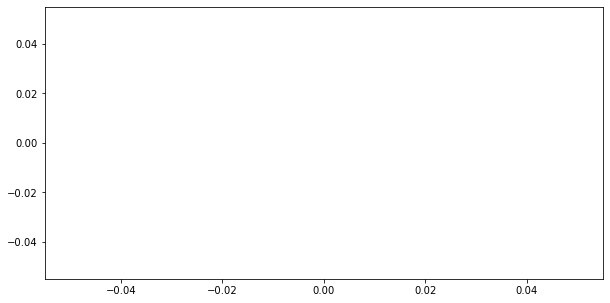

In [19]:
spike_data = spike_data[:]
spike_data_sample_plot = spike_data.reshape((config["num_steps"], -1))
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample_plot, ax, s=1.5)

In [ ]:
loss_func = nn.MSELoss() # Idk
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
loss_hist = []

In [ ]:
for epoch in range(config["no_epochs"]):
    for batch_idx, (x, y) in enumerate(train_loader):
        net.train()
        
        # forward
        y = net(x)
        loss = loss_func(x, y)
        
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Store loss history for future plotting
        loss_hist.append(loss.item())

In [ ]:
plt.plot(loss_hist)

In [ ]:
net(torch.tensor([1], dtype=torch.float32))